In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

GAMMA = 1.4 

In [3]:
def theta_from_beta(beta, M, gamma=1.4):
    """
	Returns theta (rad) for an oblique shock.
	Accepts beta as scalar or numpy array.
    """
    beta = np.asarray(beta)                     # sûreté : cast en ndarray
    term1 = 2.0 / np.tan(beta)
    term2 = M**2 * np.sin(beta)**2 - 1.0
    term3 = M**2 * (gamma + np.cos(2.0 * beta)) + 2.0
    return np.arctan(term1 * term2 / term3)     # np.arctan !

In [4]:
def bisection(beta_low, beta_high, f, tol=1e-10, max_iter=100):
	"""Find root of f(β)=0 using bisection method (β in rad)."""
	f_low = f(beta_low)
	for _ in range(max_iter):
		beta_mid = 0.5 * (beta_low + beta_high)
		f_mid = f(beta_mid)
		if abs(f_mid) < tol:
			return beta_mid
		if f_low * f_mid < 0.0:
			beta_high = beta_mid
		else:
			beta_low, f_low = beta_mid, f_mid
	raise RuntimeError("Bisection did not converge.")

In [5]:
def bracket_roots(theta_rad, M, gamma=GAMMA, n_scan=4000):
	"""
	Scan β from Mach line to 89.9°:
	returns list of intervals [β_low, β_high] where f changes sign.
	"""
	beta_min = math.asin(1.0 / M) + 1e-6
	beta_max = math.radians(89.9)

	betas = np.linspace(beta_min, beta_max, n_scan)
	f_vals = theta_from_beta(betas, M, gamma) - theta_rad

	idx = np.where(np.diff(np.sign(f_vals)))[0]      # indices where sign changes
	return [(betas[i], betas[i + 1]) for i in idx]   # one interval → one root

In [6]:
def beta_solutions(theta_deg, M, gamma=GAMMA):
    """
    Returns a list [β_weak (rad), β_strong (rad) (optional)]
    for a given (θ, M) pair. 0 or 1 or 2 solutions.
    """
    theta_rad = math.radians(theta_deg)
    intervals = bracket_roots(theta_rad, M, gamma)
    betas = []
    for beta_low, beta_high in intervals:
        betas.append(
            bisection(beta_low, beta_high,
                      lambda b: theta_from_beta(b, M, gamma) - theta_rad))
    return betas

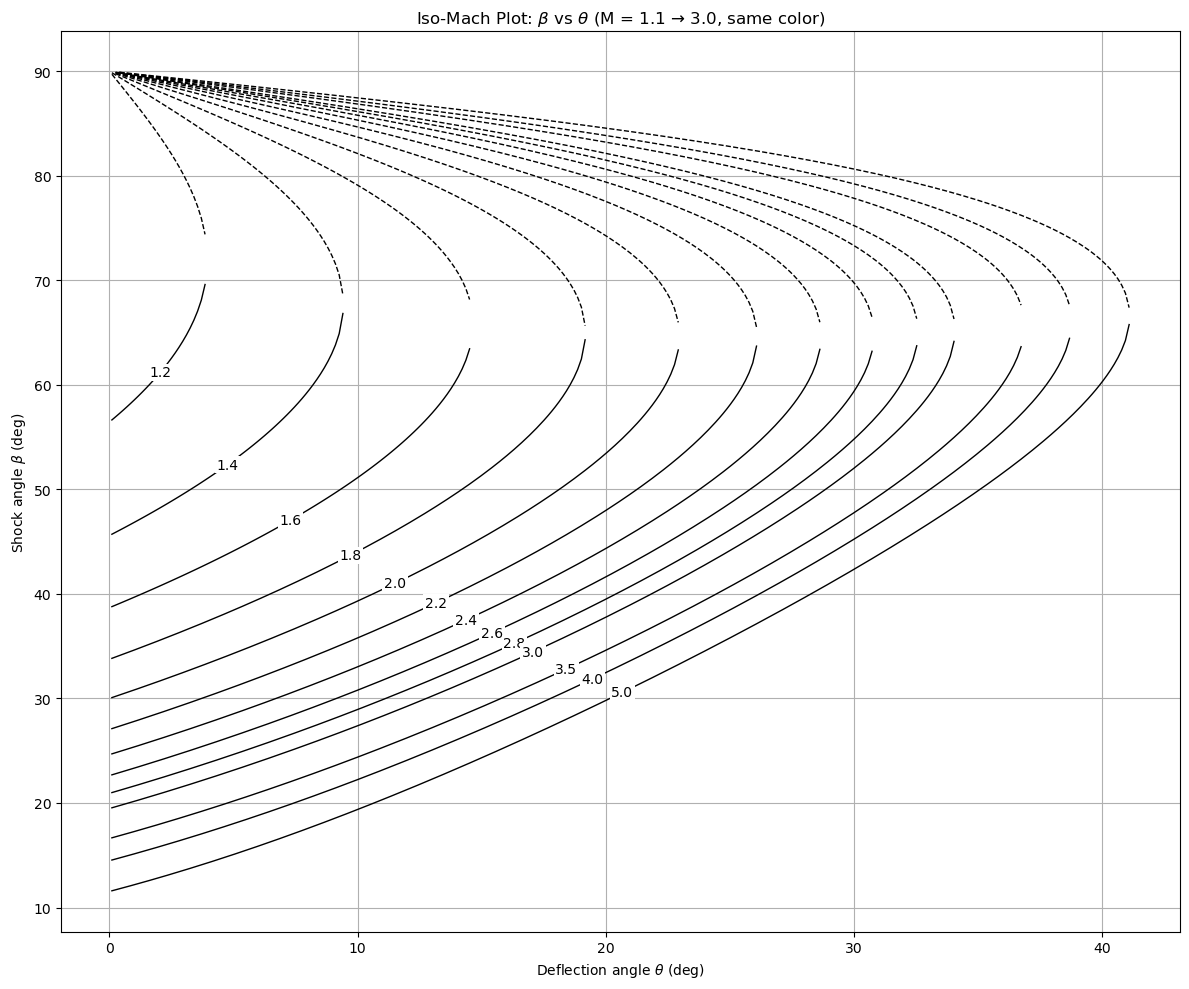

In [8]:
theta_vals = np.linspace(0.1, 45.0, 300)            # θ in degrees
mach_dense  = np.round(np.arange(1.2, 3.0, 0.2), 1) # 1.2, 1.4, …, 2.8
mach_extra  = [3.0, 3.5, 4.0, 5.0]
mach_list   = np.concatenate((mach_dense, mach_extra))

plt.figure(figsize=(12, 10))

for M in mach_list:
	weak_pts, strong_pts = [], []

	for theta in theta_vals:
		betas = beta_solutions(theta, M)            # in radians
		if not betas:
			break                                   # θ exceeds θ_max → stop

		# weak β = first root
		weak_pts.append((theta, math.degrees(betas[0])))

		# strong β = second root if it exists
		if len(betas) > 1:
			strong_pts.append((theta, math.degrees(betas[1])))

	# --- plot accumulated points --------------------------
	if weak_pts:
		t_w, b_w = zip(*weak_pts)
		plt.plot(t_w, b_w, color='black', lw=1)

		# Mach label on weak branch (middle of curve)
		mid = len(t_w) // 2
		plt.text(t_w[mid], b_w[mid], f"{M}",
				 ha="center", va="center",
				 bbox=dict(facecolor="white", edgecolor="none", pad=1.2))

	if strong_pts:
		t_s, b_s = zip(*strong_pts)
		plt.plot(t_s, b_s, color='black', lw=1, ls='--')  # dashed = strong shock

plt.xlabel(r"Deflection angle $\theta$ (deg)")
plt.ylabel(r"Shock angle $\beta$ (deg)")
plt.title(r"Iso-Mach Plot: $\beta$ vs $\theta$ (M = 1.1 → 3.0, same color)")
plt.grid(True)
plt.tight_layout()
plt.show()
